# Data Cleaning

## The problem
Following a data-centric approach, the quality of the machine learning (ML) model is highly dependent on the quality of the data used to train it. Unfortunately, despite curators best efforts, the provided data can still include errors or miss-classifications. It is a well-known issue that data scientists spend more than half their time cleaning the data. One challenge for using a dataset is that there is no "go-to" method of finding errors in the dataset, such as faulty labels or samples that do not fit the business use case.

## The solution: Coresets
Coresets refer to a sampling methodology originating in computational geometry used to approximate optimization problems. They are based on selecting a subset of the original dataset that maintains the entire dataset's statistical properties (including the corner cases). Training a model on the Coreset should give the same result as training it on the full dataset.


When computing a Coreset, every instance in the dataset is assigned an importance value, which indicates how important it is to the final ML model. Samples that receive a high importance value in the Coreset computation require the attention of the data scientist as they usually indicate a labeling error or other data-related issues. Therefore, leveraging the Coresets, we can easily assign an importance score to each sample. Instances with high importance scores have a high probability of being mislabeled. Thus, we can sample instances of interest by looking at the top percentile of importance.


In the end, by speeding up the cleaning process of the dataset, the data scientists can focus on bringing real value and not on curating tasks.


--------

## The goal of the notebook


Using the Coreset Logistic Regression Service, the importance values of all the samples within a class are calculated. Classes of interest will be picked, with potentially incorrect labels, to be cleaned.

-------


## Import dependencies

In [1]:
%%capture
!pip install gdown

In [2]:
import numpy as np
import pickle
from pathlib import Path
from time import time, strftime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import gdown

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

from dataheroes.data.utils import read_npy

In [3]:
# Load dataset class id to human-readable label dictionary
from data_cleaning_image_classification_imagenet_class_names import imagenet1k_class_names

In [4]:
# Import the logistic regression coreset tree service, which we will use to find important samples within the dataset.
from dataheroes import CoresetTreeServiceLG

In [5]:
# Ignore convergence warnings for logistic regression.
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [6]:
def fit_classifier(x_train, y_train, classifier, sample_weight=None):
    """
    Function used for fitting the train dataset on a classifier, optionally supporting the use of sample weights

    Arguments:
        x_train: training vector
        y_train: target vector relative to x_train
        classifier: the classifier to use for the classification task
        sample_weight: the weights assigned to individual samples
    Returns:
        the fitted classifier and the time it took to fit the training data
    """
    start_time = time()
    model = classifier.fit(x_train, y_train, sample_weight=sample_weight)
    duration = time() - start_time

    return model, duration

## Define constants

In [7]:
# Internal folder used by the notebook, it is created if it doesn't exists
data_root = Path('data')
# Folder containing data derived from the ImageNet-1K raw images
data_generated = data_root / 'ImageNet_1K' / 'generated'
# Folder containing a relevant selection of the ImageNet-1K raw train images
data_raw = data_root / 'ImageNet_1K' / 'raws'
# Location of the ImageNet-1K raw train and test images
ilsvrc2012_img_train_root = data_raw / "ILSVRC2012_img_train"

# Define the relevant, internal sub-folders
wd_path = data_root / 'ImageNet_1K' / 'wd'
saved_coresets_path = data_root / 'ImageNet_1K' / 'saved_csets'
pickled_path = data_root / 'pickled'

# Number of classes of importance
num_important_classes = 3

### Download necessary files

In [8]:
# Test if needed folder are created and if needed files were downloaded
if not data_generated.exists():
    # Create notebook folder structure
    data_root.mkdir(parents=True, exist_ok=True)
    data_generated.mkdir(parents=True, exist_ok=True)
    data_raw.mkdir(parents=True, exist_ok=True)
    wd_path.mkdir(parents=True, exist_ok=True)
    saved_coresets_path.mkdir(parents=True, exist_ok=True)
    pickled_path.mkdir(parents=True, exist_ok=True)
    
    # Public folder on Google Drive with necessary data
    url = "https://drive.google.com/drive/folders/1iwrxURFfcbWxCDKLWswVoV8ffcZyz9Gs"

    # Download files from Google Drive
    gdown.download_folder(url, quiet=False, use_cookies=False, output=str(data_generated))
    
    # Path to the selection of the imagenet train images
    raw_tar_archive = data_generated / "ILSVRC2012_img_train.tar"

    # Unpack the imagenet train images archive
    shutil.unpack_archive(str(raw_tar_archive), str(data_raw))
    
    # Delete the imagenet train images archive
    raw_tar_archive.unlink()
    
    # The pickle file storing the fitted LogisticRegression classifier
    pickle_filename = "fitted-logisticregression-2023_01_23-12_16_35.pickle"
    
    # Move the pickle file
    shutil.move(str(data_generated / pickle_filename), str(pickled_path / pickle_filename))

Retrieving folder list


Processing file 19sehagxKM4Ts4r04ZdUnhwQOqJWHDXQu fitted-logisticregression-2023_01_23-12_16_35.pickle
Processing file 1dt3TCLPnlq1gqatB7C0dj3T6TBmlC27O ILSVRC2012_img_train.tar
Processing file 1YlAvjm5HrF9hm1xudobPBeJHL64ExCLN img_test.npy
Processing file 19Srd4b8o1QxWBYH3Eefyhsa1rUzJdXdo img_train.npy
Processing file 1g_DOebSFWQlNPixjv7lbNmXTYCY_RSmu x_test.npy
Processing file 1mKrv0jsS0ywsuJzGpi4V_fLOf6hNngPa x_train.npy
Processing file 1cDsPYf__r6WBHDlgDh5Rm-jH6JQAplpq y_test.npy
Processing file 1rP6G36pwiqgj2tk8n6a6ajpsBzwxm7Eo y_train.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=19sehagxKM4Ts4r04ZdUnhwQOqJWHDXQu
To: /Users/khef/dataheroes/dh-library/examples/cleaning/data/ImageNet_1K/generated/fitted-logisticregression-2023_01_23-12_16_35.pickle
100%|██████████| 4.11M/4.11M [00:00<00:00, 7.64MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1dt3TCLPnlq1gqatB7C0dj3T6TBmlC27O
From (redirected): https://drive.google.com/uc?id=1dt3TCLPnlq1gqatB7C0dj3T6TBmlC27O&confirm=t&uuid=bf31eaa9-17e0-4257-b52a-c278112bb101
To: /Users/khef/dataheroes/dh-library/examples/cleaning/data/ImageNet_1K/generated/ILSVRC2012_img_train.tar
100%|██████████| 368M/368M [00:56<00:00, 6.47MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1YlAvjm5HrF9hm1xudobPBeJHL64ExCLN
To: /Users/khef/dataheroes/dh-library/examples/cleaning/data/ImageNet_1K/generated/img_test.npy
100%|██████████| 7.60M/7.60M [00:01<00:00, 4.11MB/s]
Downloading...
From (uriginal): htt

### How the features are computed


The features to be loaded are already precomputed by a different script. These were computed from the ILSVRC dataset with the following steps:
1. Initialized a ResNet18 classifier pretrained on the dataset and dropping the last classification layer in order for the model to output an embedding instead of the class distribution.
2. On top of these embeddings, one can train a logistic regression for the final classification, and use the coreset logistic regression service to compute the importance of each sample (note that there is a different coresets service for different models - this specific service is using the logistic regression model under the hood) 

**NOTE:** These steps were exported to a different script (it takes a few hours to run) in order to make this notebook as clear as possible. You can view the script <a href="https://github.com/Data-Heroes/dataheroes/blob/master/examples/feature_extraction_scripts/feature_extraction_imagenet1k_resnet18_pytorch.py">here</a>.

### Loading the dataset and its associated files

In [9]:
# Definitions of path variables for the dataset files
x_train_file = data_generated / 'x_train.npy'
y_train_file = data_generated / 'y_train.npy'
x_test_file = data_generated / 'x_test.npy'
y_test_file = data_generated / 'y_test.npy'
# Definitions of path variables for the files containing the sample-to-image association, used for plotting images
train_images_paths_file = data_generated / 'img_train.npy'
test_images_paths_file = data_generated / 'img_test.npy'

In [10]:
# Load the train data
x_train = np.load(str(x_train_file))
y_train = np.load(str(y_train_file))
# Load the test data
x_test = np.load(str(x_test_file))
y_test = np.load(str(y_test_file))
# Load the file containing relative path to the "JPEG" image files corresponding to each samples in the dataset
# The paths are relative to the `ilsvrc2012_img_train_root` for the train images and to the
#   `ilsvrc2012_img_test_root` for the test images
train_images_relative_paths = np.load(str(train_images_paths_file), allow_pickle=True)
test_images_relative_paths = np.load(str(test_images_paths_file), allow_pickle=True)

## Pick the most relevant 3 classes to look at

Compute the importance for three classes of interest. To do that, an sklearn LogisticRegression classifier will be fitted on the training data and the confusion matrix will be calculated on the test data. The worst-performing 3 categories will represent our classes of interest. 

#### Fit a LogisticRegression classifier on the train dataset

In [11]:
# Load the pickled classifier, if it exists
sorted_saved_classifiers_list = sorted(Path(pickled_path).glob('fitted-logisticregression-*.pickle'))
if len(sorted_saved_classifiers_list) > 0:
    with open(sorted_saved_classifiers_list[-1], 'rb') as f:
        clf = pickle.load(f)
    print(f"[info ]: loaded classifier from \'{sorted_saved_classifiers_list[-1].name}\'")
else:
    t_start = time()
    x_train = np.load(str(x_train_file))
    y_train = np.load(str(y_train_file))
    load_time = time() - t_start
    print(f"[info ]: loading of the train dataset lasted {load_time:.3f} seconds")

    cls = LogisticRegression()
    clf, fit_time = fit_classifier(
        x_train=x_train,
        y_train=y_train,
        classifier=cls,
    )
    print(f"[info ]: fitting the LogisticRegression classifier on the train dataset lasted {fit_time:.3f} seconds")

    pickle_filepath = pickled_path / f"fitted-logisticregression-{strftime('%Y_%m_%d-%H_%M_%S')}.pickle"
    with open(pickle_filepath, 'wb') as f:
        pickle.dump(clf, f)
    print(f"[info ]: the fitted classifier was saved to {pickle_filepath.name}")

[info ]: loaded classifier from 'fitted-logisticregression-2023_01_23-12_16_35.pickle'


#### Pick the classes based on the confusion matrix

The confusion matrix is used to find the classes that generated the most false positives. This can be explained with an example.

When computing the normalized confusion matrix (with values between 0 and 1) for five classes: A, B, C, D, and E, if the highest value in the confusion matrix correspond to the true class A and the predicted class C (ignoring the values from the main diagonal), this means that class A was confused with class C the most within the test dataset. Consequently, class C will be one of the three candidates for the classes of interest because there might be issues within the label for this class (a high confusion between classes A and C was identified).

In [12]:
y_predicted = clf.predict(x_test)
cm = confusion_matrix(y_test, y_predicted, normalize="true")
# To extract the highest confusion ignore the diagonal matrix
np.fill_diagonal(cm, 0)

In [13]:
# Sort all values in the confusion matrix in descending order
sorted_cm_values = sorted(list(set(cm.flatten().tolist())))[::-1]
# Initialize the lists of true classes ids and of predicted classed ids
true_class_ids = []
predicted_class_ids = []
# Select the highest confusion cases from the confusion matrix
for class_rank in range(num_important_classes):
    true_id, predicted_id = np.where(cm == sorted_cm_values[class_rank])
    true_class_ids = true_class_ids + [true_id[0]]
    predicted_class_ids = predicted_class_ids + [predicted_id[0]]
for case, true_id, predicted_id in zip(["first", "second", "third"], true_class_ids, predicted_class_ids):
    print(f"The {case:<6} confusion case: "
          f"the true class id \'{true_id}\' is mislabeled as class id \'{predicted_id}\' ("
          f"class:\'{imagenet1k_class_names[true_id]}\' is mislabeled as "
          f"class:\'{imagenet1k_class_names[predicted_id]}\')")

The first  confusion case: the true class id '638' is mislabeled as class id '639' (class:'maillot' is mislabeled as class:'maillot, tank suit')
The second confusion case: the true class id '620' is mislabeled as class id '681' (class:'laptop, laptop computer' is mislabeled as class:'notebook, notebook computer')
The third  confusion case: the true class id '744' is mislabeled as class id '657' (class:'projectile, missile' is mislabeled as class:'missile')


## Compute the importance using Coresets

With the help of the `CoresetTreeServiceLG` class, the samples of interest within the three classes indicated by `predicted_class_ids` will be searched for. The coreset service will compute the coreset relative to the train dataset and the logistic regression model. Afterwards, the coreset will assign importance values based on which the samples of interest will be highlighted.

#### Construct the Coreset service object

In [14]:
# Load the saved coreset, if it exists
saved_coresets_paths = [f for f in saved_coresets_path.iterdir() if f.is_dir() and f.name.startswith("coresettreeservicelg_imagenet")]
if len(saved_coresets_paths) == 1:
    t_start = time()
    coreset_obj = CoresetTreeServiceLG.load(
        dir_path    = saved_coresets_path,
        name        = f"coresettreeservicelg_imagenet"
    )
    coreset_load_time = time() - t_start
    print(f"[info ]: loading of the CoresetServiceLG object, from \'{saved_coresets_paths[0].name}\', "
          f"lasted {coreset_load_time:.3f} seconds")
else:
    t_start = time()
    coreset_obj = CoresetTreeServiceLG(
        working_directory=wd_path,
        optimized_for="cleaning",
        n_instances=len(y_train)
    )
    coreset_obj.build(
        x_train,
        y_train
    )
    coreset_build_time = time() - t_start
    
    print(f"[info ]: building of the CoresetTreeServiceLG object lasted {coreset_build_time:.3f} seconds")

    # Save the coresettreeservice object
    coreset_obj.save(
        dir_path    = saved_coresets_path,
        name        = f"coresettreeservicelg_imagenet"
    )

[info ]: building of the CoresetTreeServiceLG object lasted 126.678 seconds


In [15]:
# Define a dictionary of indices for the classes of interest
indices_dict = {}
# Define a dictionary of importance for the samples indexed by the above indices
importance_dict = {}
# Populate the indices and the importance for the classes of interest using the coreset `get_cleaning_samples`
for class_rank in range(num_important_classes):
    dictionary_result = coreset_obj.get_cleaning_samples(
        class_size={predicted_class_ids[class_rank]: "all"}
    )
    current_indices, current_importance = dictionary_result["idx"], dictionary_result["importance"]
    indices_dict[class_rank] = current_indices
    importance_dict[class_rank] = current_importance

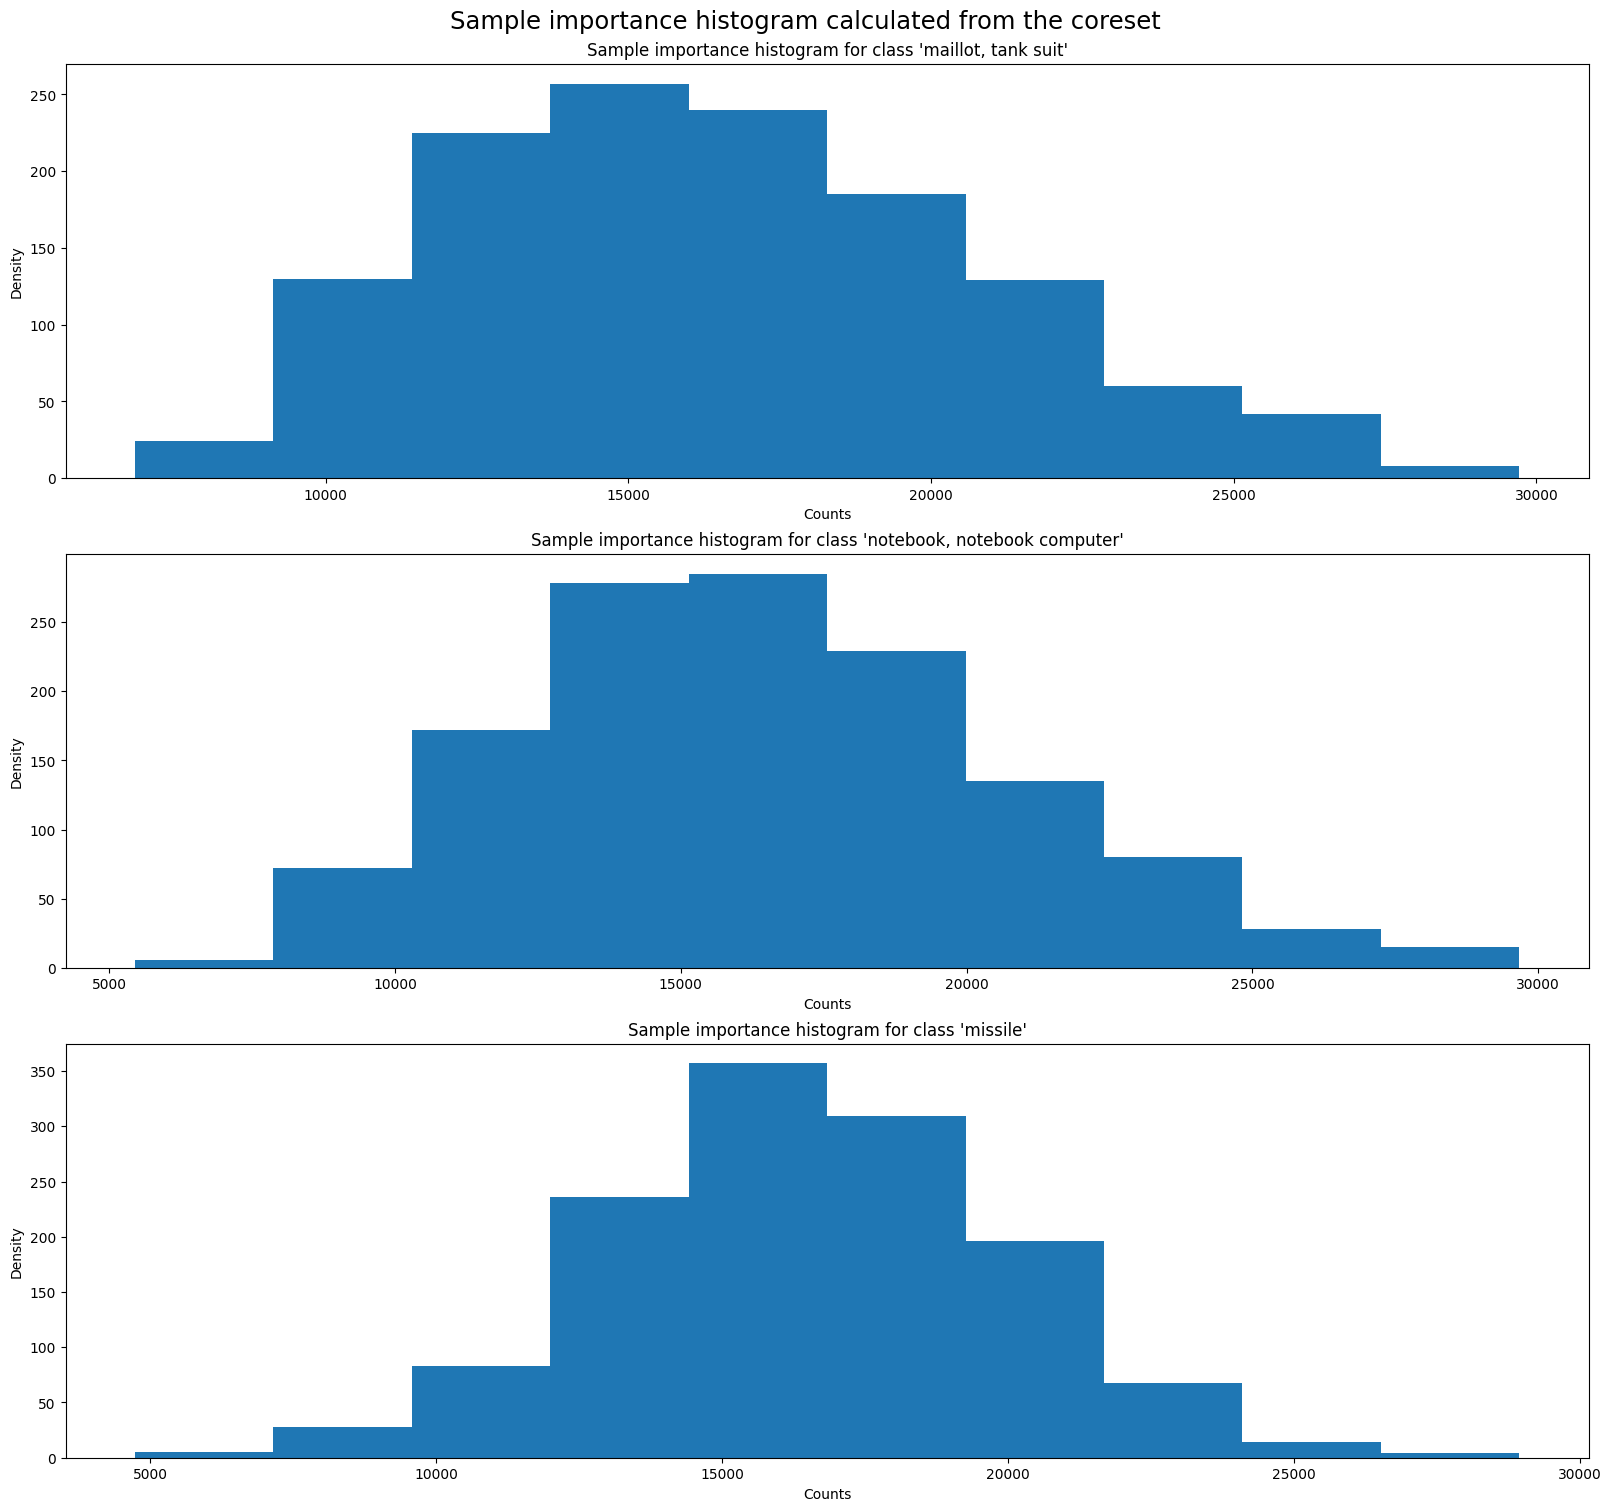

In [16]:
fig, ax = plt.subplots(num_important_classes, 1, figsize=(16, 15), constrained_layout=True)
fig.suptitle(f"Sample importance histogram calculated from the coreset", fontsize=17.5)
for class_rank in range(num_important_classes):
    ax[class_rank].set_title(f"Sample importance histogram for class "
                               f"\'{imagenet1k_class_names[predicted_class_ids[class_rank]]}\'")
    ax[class_rank].set_xlabel("Counts")
    ax[class_rank].set_ylabel("Density")
    _ = ax[class_rank].hist(importance_dict[class_rank], bins=10)

## Visualize samples sorted by importance

The objective is to visualize the data samples from the top and bottom ends of the importance spectrum based on the importance computed using the coreset service.

It is to note that the coreset service returns the indices and the importances in importances' descending order.

In [17]:
# Build a dictionary with lists of tuples of form (index, importance) for the classes of interest, ordered in
# descending order of importance
important_samples = {rank: list(zip(indices_dict[rank], importance_dict[rank])) for rank in
                     range(num_important_classes)}
# Build a dictionary with lists of tuples of form (index, importance) for the classes of interest, ordered in
# ascending order of importance
reverse_important_samples = {rank: important_samples[rank][::-1] for rank in range(num_important_classes)}

In [18]:
def plot_images(image_indices):
    """
    Displays a number of 3 images specified by their indices in the ImagNet-1K dataset
    
    Argsuments:
        indices: list of 3 indices for the images to display
    """
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for i, idx in enumerate(image_indices):
        ax[i].axis('off')
        ax[i].imshow(
            mpimg.imread(ilsvrc2012_img_train_root / train_images_relative_paths[idx]), aspect='equal')
        ax[i].title.set_text(f"{i+1}")

def visualize(important_samples, class_rank):
    """
    Generator used to plot 6 relevant samples (top or bottom importance) for the specified class of importance

    Args:
        important_samples: dictionary with lists of tuples of form (index, importance) for the classes of interest
        class_rank: indicate the class of importance to visualize, having value from 0 to num_important_classes-1
    """
    split_tuples = [tuple(important_samples[class_rank][i:i + 6]) for i in
                      range(0, len(important_samples[class_rank]), 6)]
    for tuples in split_tuples:
        fig, ax = plt.subplots(2, 3, figsize=(10, 6))
        for i, t in enumerate(tuples):
            row, column = i // 3, i % 3
            ax[row, column].axis('off')
            ax[row, column].imshow(
                mpimg.imread(ilsvrc2012_img_train_root / train_images_relative_paths[t[0]]),
                aspect='equal')
            ax[row, column].title.set_text(f"{i+1}")
        yield

The next step is to find hard-to-predict samples (unusual objects, occluded, multiple objects instead of one, etc.) or mislabeled samples within the top-importance samples.

In [19]:
top_importance_visualizer = {class_rank : visualize(important_samples, class_rank) for class_rank in range(3)}
bottom_importance_visualizer = {class_rank : visualize(reverse_important_samples, class_rank) for class_rank in range(3)}

#### Top important samples in the `maillot, tank suit` class

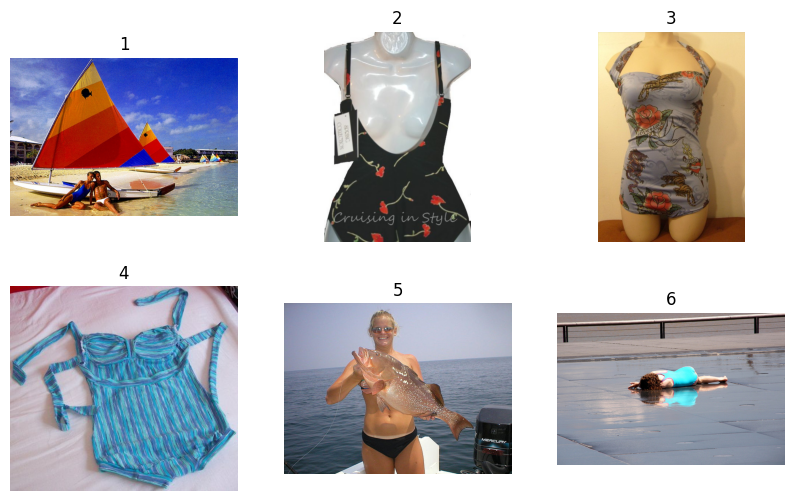

In [20]:
next(top_importance_visualizer[0])

The most important samples in the `maillot, tank suit` class: image number 1 is the most important sample and image number 6 is the sixth most important in the class. Among the top-importance samples of the `maillot, tank suit` class, one expects to find outliers that can cause problems in the statistical procedures: samples that are either difficult to predict (images containing multiple objects of relevance instead of one, images containing other objects beside the object of relevance, images having confusing backgrounds, to name only a few possible cases) or samples that are mislabeled.

#### Bottom important samples in the `maillot, tank suit` class

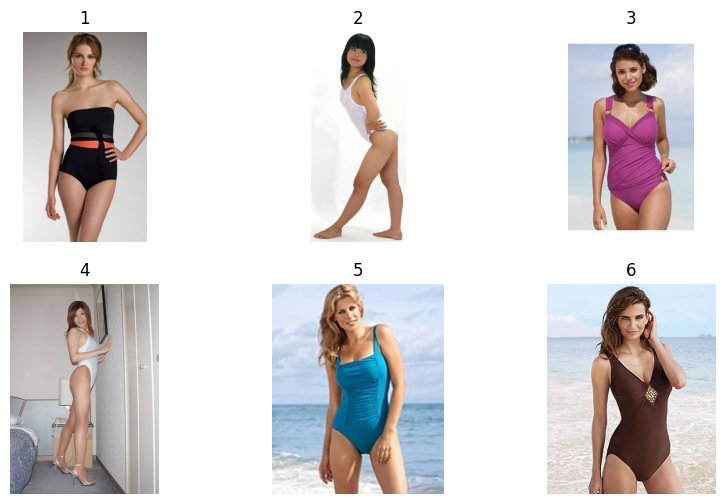

In [21]:
next(bottom_importance_visualizer[0])

The least important samples in the `maillot, tank suit` class: image number 1 is the least important image in the class and image number 6 is the sixth least important image in the same `maillot, tank suit` class. Within the bottom-importance samples of a class, one is expected to find samples that are easier to classify and, thus, are correctly labeled.

#### Mislabeled samples in the `maillot, tank suit` class

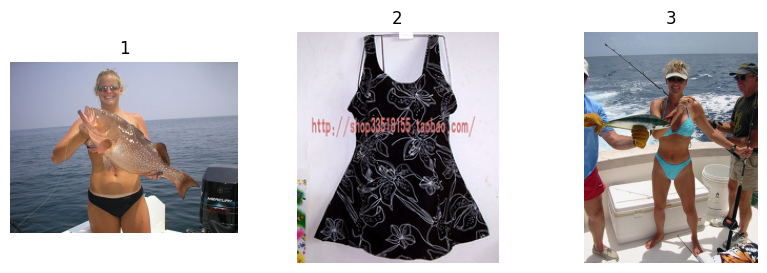

In [22]:
plot_images([821000, 820941, 821052])

The first mislabeled image in the `maillot, tank suit` class is clearly a classification error. The second image, altough, to some extent similar, depicts a dress. The third images, in the same line as the first one, is clearly mislabeled.

#### Top important samples in the `notebook, notebook computer` class

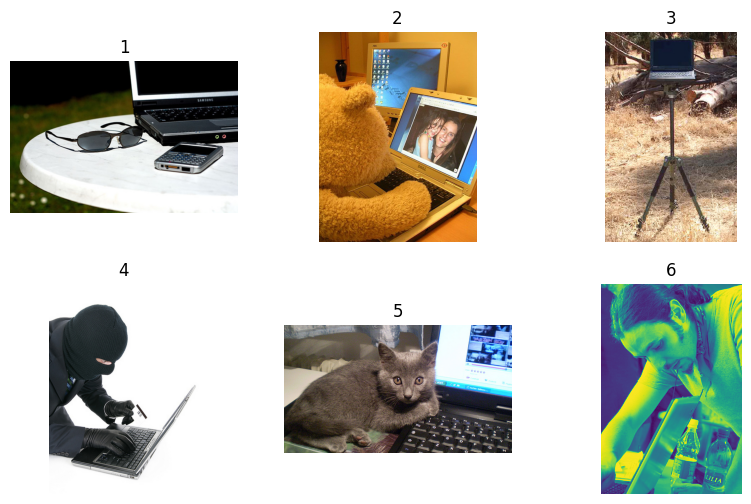

In [23]:
next(top_importance_visualizer[1])

The most important samples in the `notebook, notebook computer` class: image number 1 is the most important sample and image number 6 is the sixth most important in the class. Because all 6 top important samples of the `notebook, notebook computer` class could be easily classified in the `laptop, laptop computer` class (another, distinct, class in the dataset), this emphasizes an underlying issue with the classes of this dataset, since "class overlapping has long been regarded as one of the toughest pervasive problems in classification" [Reference.1 - accessed 01.18.2023](https://www.atlantis-press.com/article/2053.pdf).

#### Bottom important samples in the `notebook, notebook computer` class

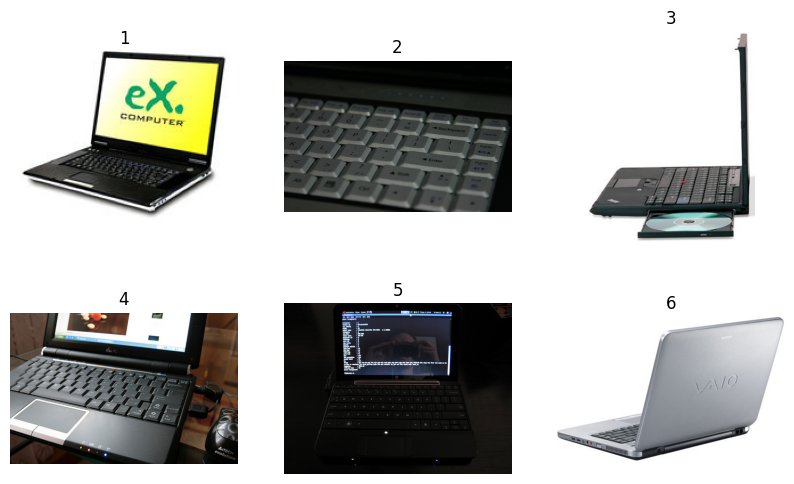

In [24]:
next(bottom_importance_visualizer[1])

The least important samples in the `notebook, notebook computer` class: image number 1 is the least important image in the class and image number 6 is the sixth least important image in the class. With the sole exception of image number 2 (which is hard to classify), all other bottom-importance images belong to the `notebook, notebook computer` class.

#### Mislabeled samples in the `notebook, notebook computer` class

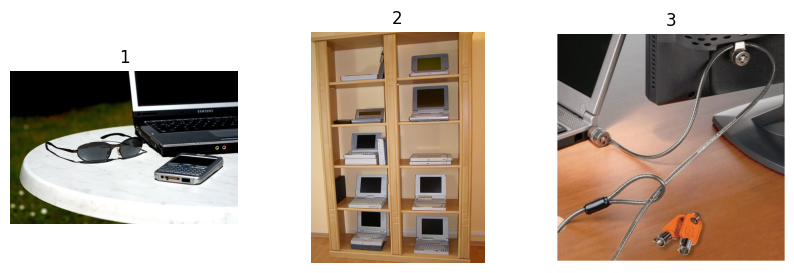

In [25]:
plot_images([874254, 874008, 874650])

The first mislabeled image could be better classified as belonging to the `laptop, laptop computer` class (given the "lightweight portability advantage" of notebooks over the laptops, [Reference.2 - accessed 01.18.2023](https://www.hp.com/us-en/shop/tech-takes/laptop-vs-notebook)). The second image has multiple objects of relevance and at least some of them could be better classified as being a laptop, so it is mislabeled too. In the third image, the object of relevance is only marginally visible, which, coupled with the presence of other objects, renders the image as mislabeled.

#### Top important samples in the `missile` class

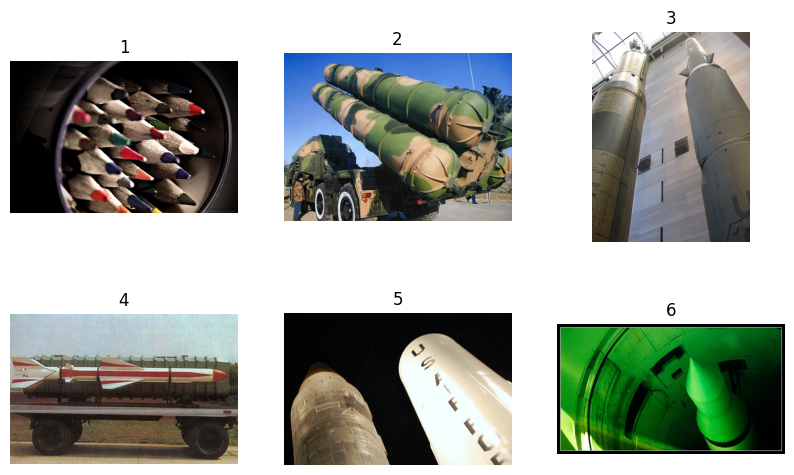

In [26]:
next(top_importance_visualizer[2])

The most important samples in the `missile` class: image number 1 is the most important sample and image number 6 is the sixth most important in the class. Some of the top-importance samples of the `missile` class are expected to be either mislabeld or to pose significant prediction difficulties (images containing occluded objects of relevance, images containing multiple objects of relevance, images with unusual colors or backgrounds).

#### Bottom important samples in the `missile` class

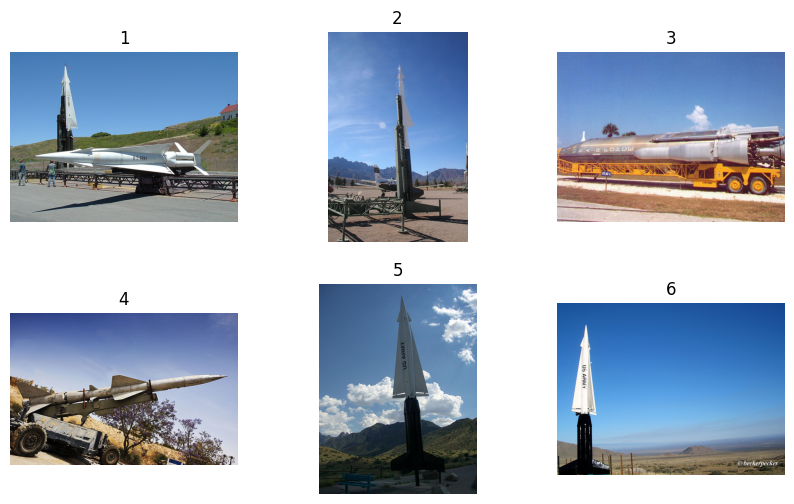

In [27]:
next(bottom_importance_visualizer[2])

The least important samples in the `missile` class: image number 1 is the least important image in its class and image number 6 is the sixth least important image in the class. The majority of images from the bottom-importance spectrum of the `missile` class are images with only a single item of relevance, making them considerably easier to classify.

#### Mislabeled samples in the `missile` class

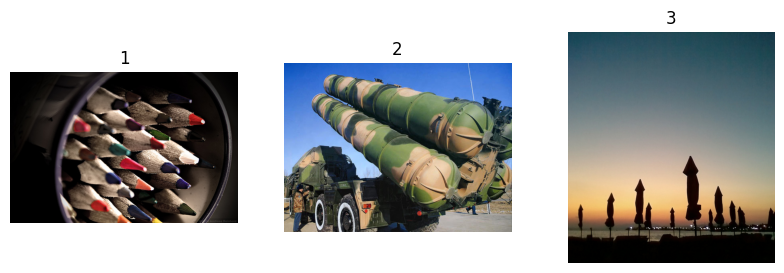

In [28]:
plot_images([843935, 843625, 843690])

The first mislabeled image in the `missile` class, as can be seen, is clearly incorrectly classified (though there is some sort of resemblance). The second image, although semantically connected, depicts "the 5P85CM self-propelled launcher" [Reference.3 - accessed 01.18.2023](https://en.missilery.info/missile/c300pmu1) and is, therefore, mislabeled too. The third image is clearly mislabeled.